RandomManager created with root seed 31.
All deterministic RNG streams created.

--- Common Setup ---
Shadowing map generated (will be identical for all topologies).
Placed 10 nodes randomly (positions will be identical for all topologies).

=== Random Connected ===
Constructed random links using a dedicated stream: total links = 18


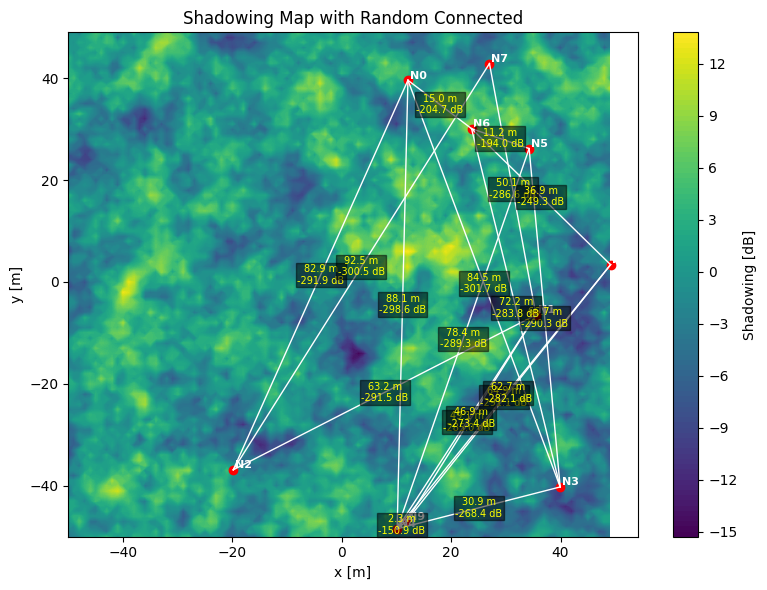

Shadowing stats: mean = -0.12 dB, std dev = 3.96 dB (target 4 dB)

=== Star Topology ===
Constructed star links using a dedicated stream: total links = 9


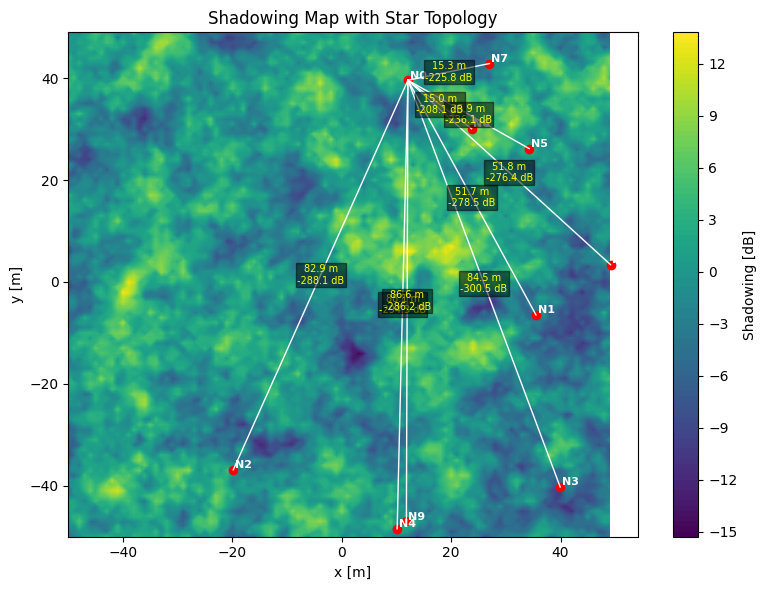

Shadowing stats: mean = -0.12 dB, std dev = 3.96 dB (target 4 dB)

=== Tree Topology ===
Constructed tree links using a dedicated stream: total links = 9


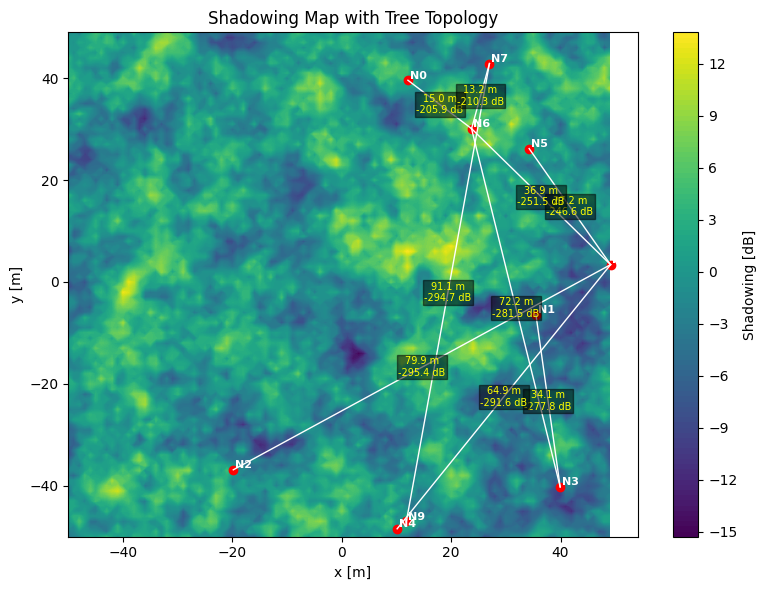

Shadowing stats: mean = -0.12 dB, std dev = 3.96 dB (target 4 dB)

=== Ring Topology ===
Constructed ring links using a dedicated stream: total links = 10


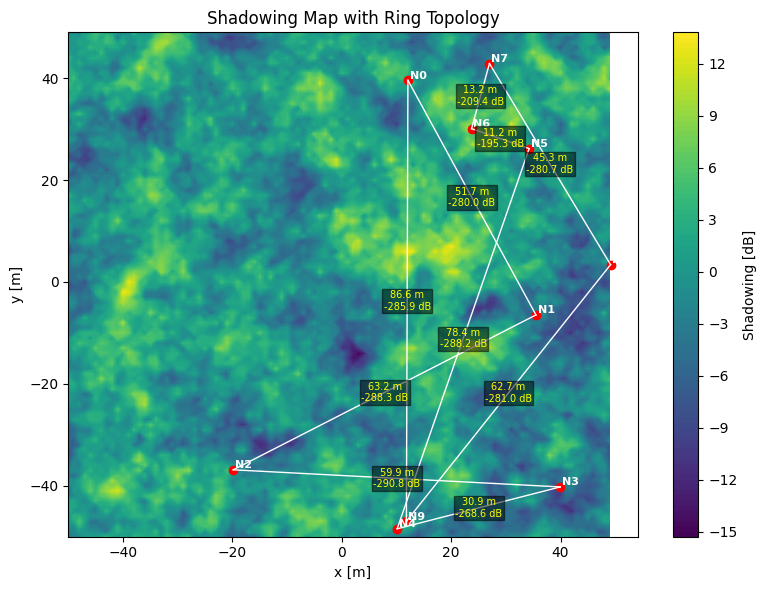

Shadowing stats: mean = -0.12 dB, std dev = 3.96 dB (target 4 dB)

=== Line Topology ===
Constructed line links using a dedicated stream: total links = 9


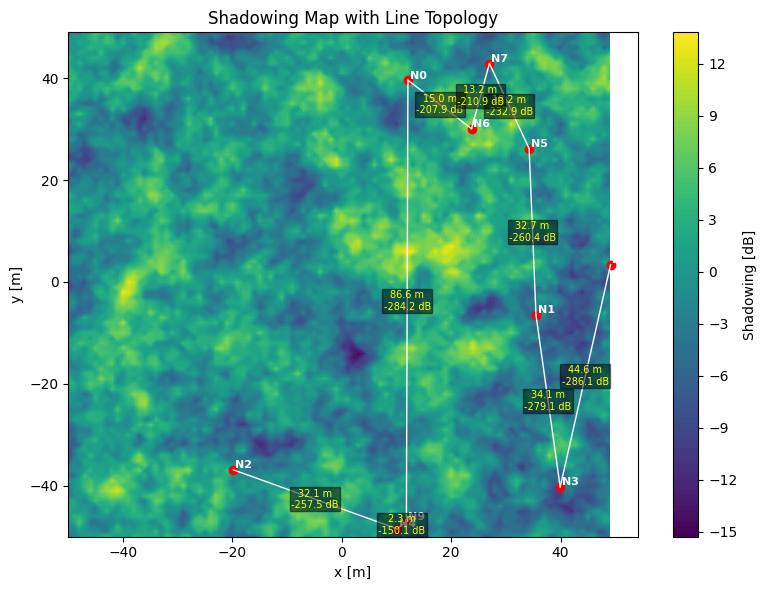

Shadowing stats: mean = -0.12 dB, std dev = 3.96 dB (target 4 dB)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import hashlib
from typing import Dict
from numpy.random import Generator, Philox

from simulator.engine.RandomManager import RandomManager

# === Make imports work ===
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.insert(0, project_root)
from simulator.models.topology import DSpace, CartesianCoordinate, Topology
# This now assumes ChannelModel is updated as described above
from simulator.models.ChannelModel import ChannelModel

# === RandomManager Setup ===
# The single root seed for the entire simulation. Replaces np.random.seed().
ROOT_SEED = 31
rand_manager = RandomManager(root_seed=ROOT_SEED)
print(f"RandomManager created with root seed {ROOT_SEED}.")

# === Simulation parameters ===
dspace_step   = 1        # grid resolution [m]
dspace_npt    = 100      # 100×100 grid
freq          = 2.4e9    # signal frequency [Hz]
coh_d         = 5        # shadowing coherence distance [m]
shadow_dev    = 4        # shadowing σ [dB]
pl_exponent   = 3        # path-loss exponent
d0            = 1        # reference distance [m]
fading_shape  = 10.0     # Nakagami m
n_points      = 10       # number of nodes
link_prob     = 0.2      # probability of each extra link in random graph

# === Topology configurations ===
topo_configs = [
    {"name": "Random Connected", "type": "random"},
    {"name": "Star Topology",     "type": "star"},
    {"name": "Tree Topology",     "type": "tree"},
    {"name": "Ring Topology",     "type": "ring"},
    {"name": "Line Topology",     "type": "line"},
]

# === PRE-CREATE ALL DETERMINISTIC STREAMS ===
# By creating streams upfront, we ensure each source of randomness is
# independent and perfectly reproducible.
rand_manager.create_stream("shadowing")  # For the channel's shadowing map
rand_manager.create_stream("placement")  # For node positions
for cfg in topo_configs:
    # A dedicated, unique stream for each topology's link generation
    rand_manager.create_stream(f'topology_{cfg["type"]}')
print("All deterministic RNG streams created.")


# The build_topology function remains the same, as it correctly
# accepts and uses a passed 'rng' object.
def build_topology(topo: Topology, ttype: str, rng: np.random.Generator):
    """Add links to 'topo' according to the requested type."""
    if ttype == "random":
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)
        for u in topo.node_ids:
            neigh = set(topo.get_neighbors(u))
            for v in topo.node_ids:
                if v > u and v not in neigh and rng.random() < link_prob:
                    topo.add_link(u, v)
    elif ttype == "star":
        center = topo.node_ids[0]
        for other in topo.node_ids:
            if other != center:
                topo.add_link(center, other)
    elif ttype == "tree":
        nodes = topo.node_ids.copy()
        rng.shuffle(nodes)
        for i in range(1, len(nodes)):
            u, v = nodes[i], rng.choice(nodes[:i])
            topo.add_link(u, v)
    elif ttype == "ring":
        ids = topo.node_ids
        for i in range(len(ids)):
            u, v = ids[i], ids[(i+1) % len(ids)]
            topo.add_link(u, v)
    elif ttype == "line":
        sorted_nodes = sorted(topo.node_ids, key=lambda nid: topo.get_node_coordinate(nid).x)
        for i in range(len(sorted_nodes)-1):
            u, v = sorted_nodes[i], sorted_nodes[i+1]
            topo.add_link(u, v)
    else:
        raise ValueError(f"Unknown topology type: {ttype}")


# === UNIFIED SETUP (performed only ONCE) ===
# These elements are now fixed across all topology configurations for a fair comparison.
print("\n--- Common Setup ---")

# 1) Create shadowing map using its dedicated stream
shadow_rng = rand_manager.get_stream("shadowing")
dspace = DSpace(dspace_step=dspace_step, dspace_npt=dspace_npt)
model  = ChannelModel(
    dspace=dspace, freq=freq, coh_d=coh_d, shadow_dev=shadow_dev,
    pl_exponent=pl_exponent, d0=d0, fading_shape=fading_shape,
    rng=shadow_rng  # Pass the dedicated generator to the updated model
)
model.generate_shadowing_map()
print("Shadowing map generated (will be identical for all topologies).")

# 2) Place nodes at random positions using their dedicated stream
placement_rng = rand_manager.get_stream("placement")
raw_pts = placement_rng.uniform(-dspace._size/2, dspace._size/2, size=(n_points, 2))
print(f"Placed {n_points} nodes randomly (positions will be identical for all topologies).")


# === Main loop over each configuration ===
# Now, the loop only builds the links on the same set of nodes and map.
for cfg in topo_configs:
    name, ttype = cfg["name"], cfg["type"]
    print(f"\n=== {name} ===")

    # 1) Build graph and add the pre-calculated nodes
    topo = Topology()
    for idx, (x, y) in enumerate(raw_pts):
        coord = CartesianCoordinate(np.float64(x), np.float64(y))
        topo.add_node(node_id=idx, coordinate=coord)
    
    # 2) Get the dedicated RNG for THIS specific topology's link generation
    build_rng = rand_manager.get_stream(f"topology_{ttype}")

    # 3) Add links per chosen topology
    build_topology(topo, ttype, build_rng)
    total_links = sum(len(topo.get_neighbors(n)) for n in topo.node_ids) // 2
    print(f"Constructed {ttype} links using a dedicated stream: total links = {total_links}")

    # 4) Plot shadowing map with contourf and overlay the topology
    fig, ax = plt.subplots(figsize=(8,6))
    cs = ax.contourf(dspace.X, dspace.Y, model.shadowing_map, levels=100, cmap='viridis')
    ax.set_title(f"Shadowing Map with {name}")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    for node_id in topo.node_ids:
        P = topo.get_node_coordinate(node_id)
        ax.plot(P.x, P.y, 'ro')
        ax.text(P.x + 0.3, P.y + 0.3, f"N{node_id}", color='white', fontsize=8, weight='bold')
    seen = set()
    for u in topo.node_ids:
        for v in topo.get_neighbors(u):
            if (v,u) in seen: continue
            seen.add((u,v))
            A, B = topo.get_node_coordinate(u), topo.get_node_coordinate(v)
            ax.plot([A.x, B.x], [A.y, B.y], 'w-', linewidth=1)
            distance = dspace.distance(A, B)
            loss_dB  = model.total_link_loss(A, B)
            mx, my = (A.x + B.x)/2, (A.y + B.y)/2
            ax.text(mx, my, f"{distance:.1f} m\n{loss_dB:.1f} dB", color='yellow',
                    fontsize=7, ha='center', va='center',
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))
    fig.colorbar(cs, ax=ax, label='Shadowing [dB]')
    plt.tight_layout()
    plt.show()

    # 5) Print summary statistics
    mean_sh = model.shadowing_map.mean()
    std_sh  = model.shadowing_map.std()
    print(f"Shadowing stats: mean = {mean_sh:.2f} dB, std dev = {std_sh:.2f} dB (target {shadow_dev} dB)")
